**<H1>PREDICT THE CANCER MORTALITY RATE PER CAPITA</h1>**

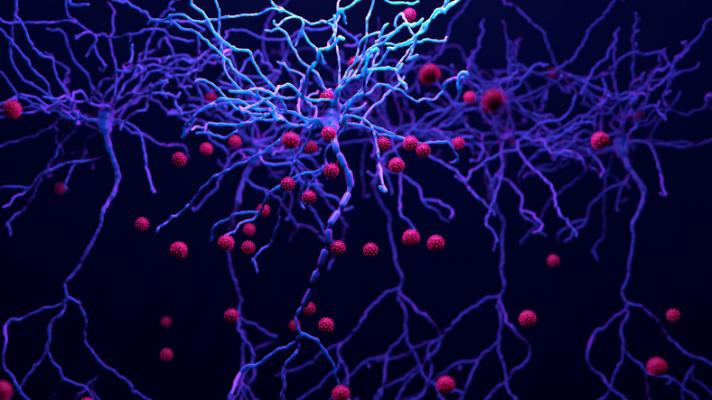

The defination of Cancer Mortality rate  is can be defined as the cancer death rate (cancer mortality) is 158.3 per 100,000 men and women per year (based on 2013–2017 deaths). The cancer mortality rate is higher among men than women (189.5 per 100,000 men and 135.7 per 100,000 women).

**<H2>Problem Statement</H2>**

Based on the given dataset with huge variables need to predict the cancer mortality rate per capita.

**<H2>Perfomance Metric</H2>**

**MAE**: Mean Absolute Error is the performance matric which is used here. This is because as the columns are more it is very difficult to find the outliers in each column and deal with them individually. Hence in order to ignore the outliers and  check the performance MAE is used.

In [1]:
#Importing All the libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.model_selection import train_test_split
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#mounting google drive to get dataset from drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#reading the data 
data=pd.read_csv("/content/drive/MyDrive/cancer_reg (1).csv", encoding='latin-1')  #Here Latin1 encodes only the first 256 code points of the Unicode character set.
data.head(10) #First 10 rows of dataset

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,MedianAgeFemale,Geography,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",2.54,52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",2.34,44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",2.62,54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",2.52,52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",2.34,57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
5,428.0,152,176.0,505.4,52313,61023,15.6,180.259902,"(51046.4, 54545.6]",45.4,43.5,48.0,"Mason County, Washington",2.58,50.4,29.9,35.1,NaN,4.5,30.4,11.9,44.1,12.9,60.0,38.8,32.6,43.2,20.2,84.882631,1.653205,1.538057,3.314635,51.220360,4.964476
6,250.0,97,175.9,461.8,37782,41516,23.2,0.000000,"(37413.8, 40362.7]",42.6,42.2,43.5,"Okanogan County, Washington",2.42,54.1,26.1,41.4,NaN,5.8,29.8,11.9,51.8,8.9,49.5,35.0,28.3,46.4,28.7,75.106455,0.616955,0.866157,8.356721,51.013900,4.204317
7,146.0,71,183.6,404.0,40189,20848,17.8,0.000000,"(37413.8, 40362.7]",51.7,50.8,52.5,"Pacific County, Washington",2.24,52.7,27.3,33.9,36.5,2.2,31.6,11.3,40.9,8.9,55.8,33.1,25.9,50.9,24.1,89.406636,0.305159,1.889077,2.286268,48.967033,5.889179
8,88.0,36,190.5,459.4,42579,13088,22.3,0.000000,"(40362.7, 42724.4]",49.3,48.4,49.8,"Pend Oreille County, Washington",2.38,55.9,34.7,39.4,NaN,1.4,32.2,12.0,39.5,10.3,55.5,37.8,29.9,48.1,26.6,91.787477,0.185071,0.208205,0.616903,53.446998,5.587583
9,4025.0,1380,177.8,510.9,60397,843954,13.1,427.748432,"(54545.6, 61494.5]",35.8,34.7,37.0,"Pierce County, Washington",2.65,50.0,15.6,36.3,NaN,7.1,28.8,16.2,56.6,9.2,69.9,NaN,44.4,31.4,16.5,74.729668,6.710854,6.041472,2.699184,50.063573,5.533430


 **<H2>Data Cleaning</H2>**

In [5]:
#Checking if dataset has any null values

data.isnull().sum()

avgAnnCount                   0
avgDeathsPerYear              0
TARGET_deathRate              0
incidenceRate                 0
medIncome                     0
popEst2015                    0
povertyPercent                0
studyPerCap                   0
binnedInc                     0
MedianAge                     0
MedianAgeMale                 0
MedianAgeFemale               0
Geography                     0
AvgHouseholdSize              0
PercentMarried                0
PctNoHS18_24                  0
PctHS18_24                    0
PctSomeCol18_24            2285
PctBachDeg18_24               0
PctHS25_Over                  0
PctBachDeg25_Over             0
PctEmployed16_Over          152
PctUnemployed16_Over          0
PctPrivateCoverage            0
PctPrivateCoverageAlone     609
PctEmpPrivCoverage            0
PctPublicCoverage             0
PctPublicCoverageAlone        0
PctWhite                      0
PctBlack                      0
PctAsian                      0
PctOther

Looking at above data there are 3 column where there are Null values. column  PctSomeCol18_24 has 2285 Null values and PctPrivateCoverageAlone  which has 609 Null values and column PctEmployed16_Over  has 150 null values. Null values of all these columns are replaced   with the mean of all values in that perticular column. 

In [6]:
#Replacing Null values with mean of all values of PctEmployed16_Over column
mean = data["PctEmployed16_Over"].mean()
data["PctEmployed16_Over"].fillna(mean,inplace=True)
mean1 = data["PctPrivateCoverageAlone"].mean()
data["PctPrivateCoverageAlone"].fillna(mean1,inplace=True)
mean3 = data["PctSomeCol18_24"].mean()
data["PctSomeCol18_24"].fillna(mean3,inplace=True)

In [7]:
#As 2 columns of dataset has object data type hence doing One Hot Encoding which is required for further analysis

x1=pd.get_dummies(data['Geography'].apply(lambda x:x.split(',')[1]))
x2=pd.get_dummies(data['binnedInc'])

def merg(df,data):
  for col in df.columns:
    data[col]=df[col]
  return data
data=merg(x1,data)   
data=merg(x2,data)             


In [8]:
#Dropping 2 columns as their dummies are created
data.drop(columns=["Geography", "binnedInc"], inplace=True, axis=1)

In [9]:
#dropping duplicate values

data.drop_duplicates()
data.shape

(3047, 93)

In [10]:
data.head(10)


,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,"(34218.1, 37413.8]","(37413.8, 40362.7]","(40362.7, 42724.4]","(42724.4, 45201]","(45201, 48021.6]","(48021.6, 51046.4]","(51046.4, 54545.6]","(54545.6, 61494.5]","(61494.5, 125635]","[22640, 34218.1]"
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,39.3,36.9,41.7,2.54,52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.9,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,33.0,32.2,33.7,2.34,44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.9,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,45.0,44.0,45.8,2.62,54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.9,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,42.8,42.2,43.4,2.52,52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.3,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,48.3,47.8,48.9,2.34,57.8,14.9,43.0,40.000000,2.0,33.4,15.0,48.2,4.8,61.6,43.900000,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
5,428.0,152,176.0,505.4,52313,61023,15.6,180.259902,45.4,43.5,48.0,2.58,50.4,29.9,35.1,40.977034,4.5,30.4,11.9,44.1,12.9,60.0,38.800000,32.6,43.2,20.2,84.882631,1.653205,1.538057,3.314635,51.220360,4.964476,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
6,250.0,97,175.9,461.8,37782,41516,23.2,0.000000,42.6,42.2,43.5,2.42,54.1,26.1,41.4,40.977034,5.8,29.8,11.9,51.8,8.9,49.5,35.000000,28.3,46.4,28.7,75.106455,0.616955,0.866157,8.356721,51.013900,4.204317,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
7,146.0,71,183.6,404.0,40189,20848,17.8,0.000000,51.7,50.8,52.5,2.24,52.7,27.3,33.9,36.500000,2.2,31.6,11.3,40.9,8.9,55.8,33.100000,25.9,50.9,24.1,89.406636,0.305159,1.889077,2.286268,48.967033,5.889179,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
8,88.0,36,190.5,459.4,42579,13088,22.3,0.000000,49.3,48.4,49.8,2.38,55.9,34.7,39.4,40.977034,1.4,32.2,12.0,39.5,10.3,55.5,37.800000,29.9,48.1,26.6,91.787477,0.185071,0.208205,0.616903,53.446998,5.587583,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
9,4025.0,1380,177.8,510.9,60397,843954,13.1,427.748432,35.8,34.7,37.0,2.65,50.0,15.6,36.3,40.977034,7.1,28.8,16.2,56.6,9.2,69.9,48.453774,44.4,31.4,16.5,74.729668,6.710854,6.041472,2.699184,50

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              3047 non-null   float64
 1   avgDeathsPerYear         3047 non-null   int64  
 2   TARGET_deathRate         3047 non-null   float64
 3   incidenceRate            3047 non-null   float64
 4   medIncome                3047 non-null   int64  
 5   popEst2015               3047 non-null   int64  
 6   povertyPercent           3047 non-null   float64
 7   studyPerCap              3047 non-null   float64
 8   MedianAge                3047 non-null   float64
 9   MedianAgeMale            3047 non-null   float64
 10  MedianAgeFemale          3047 non-null   float64
 11  AvgHouseholdSize         3047 non-null   float64
 12  PercentMarried           3047 non-null   float64
 13  PctNoHS18_24             3047 non-null   float64
 14  PctHS18_24              

**<H2>Data Visualization</H2>**

In [ ]:

# Creating Correlation Matrix and plotting HeatMap
plt.figure(figsize=(100,100))
sns.heatmap(data.corr(),linewidths=0.30,cmap ='RdYlGn',annot=True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

This is very huge to understand. Hence visualize few features vs target variable to undertsand the relation between them.

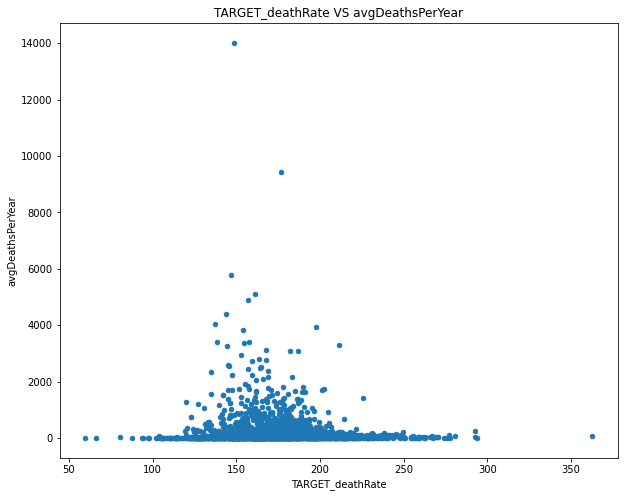

In [ ]:
data.plot.scatter(x="TARGET_deathRate", y="avgDeathsPerYear", figsize=(10,8))
plt.title("TARGET_deathRate VS avgDeathsPerYear")
plt.show()

**Observation:** There is no much relation between the target variable TARGET_deathRate and avgDeathPerYear. Most of avgDeathsPerYear is stagnent as TARGET_deathRate increases. But for the TARGET_deathRate 150 the avgDeathsPerYear is 14000 which is heighest.

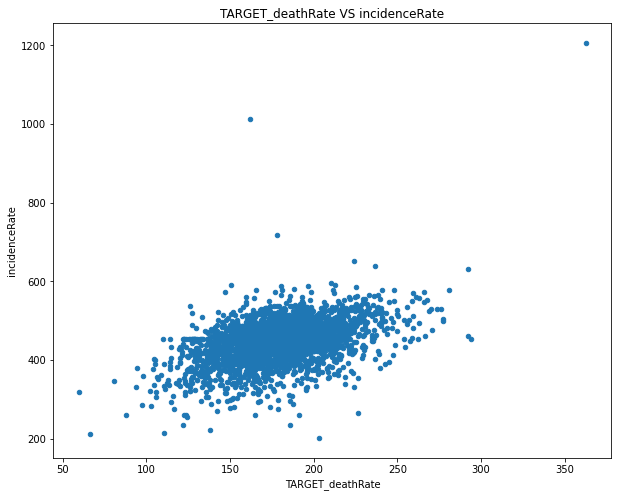

In [ ]:
data.plot.scatter(x="TARGET_deathRate", y="incidenceRate", figsize=(10,8))
plt.title("TARGET_deathRate VS incidenceRate")
plt.show()

**Observation:** As per above graph incidenceRate increases as TARGET_deathRate increases.  But for the maximum value of TARGET_deathRate 350 the avgDeathsPerYear is 14000 which is heighest.

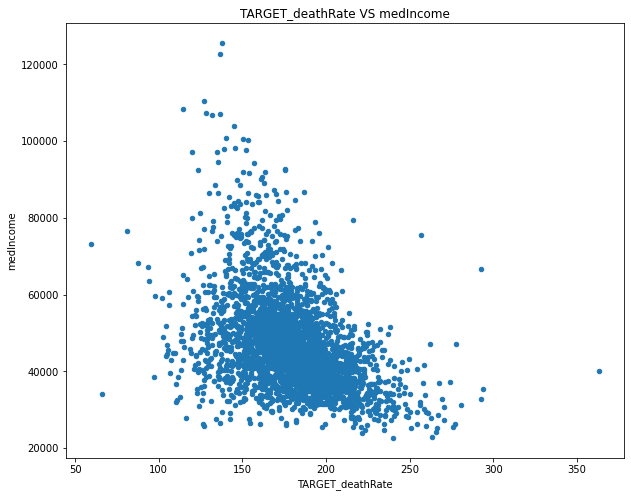

In [ ]:
data.plot.scatter(x="TARGET_deathRate", y="medIncome", figsize=(10,8))
plt.title("TARGET_deathRate VS medIncome")
plt.show()

**Observation:** As per above graph medIncome decreases as TARGET_deathRate increases.  But for the maximum value of medIncome  the TARGET_deathRate  is around 125

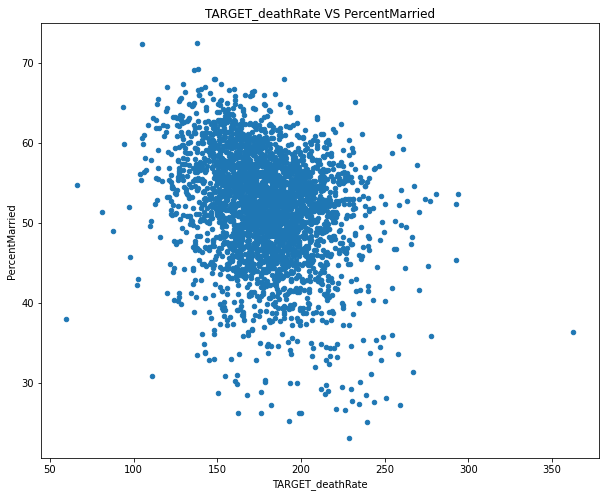

In [ ]:
data.plot.scatter(x="TARGET_deathRate", y="PercentMarried", figsize=(10,8))
plt.title("TARGET_deathRate VS PercentMarried")
plt.show()

**Observation:** As per above graph PercentMarried as TARGET_deathRate increases. Around 38% of married people have deathrate of more than 350 which is heighest.

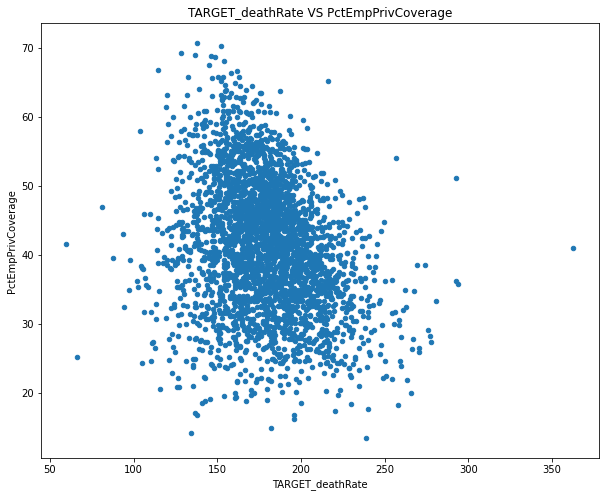

In [ ]:
data.plot.scatter(x="TARGET_deathRate", y="PctEmpPrivCoverage", figsize=(10,8))
plt.title("TARGET_deathRate VS PctEmpPrivCoverage")
plt.show()

By observing all above graphs it is like features are not completely or even around 50% dependent on Target variable. We have total 93 features which are very high to build a model. Hence featurization is required to select top features

 **<H2>Featurization<H2>**

In [11]:
#Splitting data into train and test before featurization because to avoid overfitting
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]
X = data.drop('TARGET_deathRate',axis=1)
y = data['TARGET_deathRate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

For feature selection  mutual_info_regression is used. **Mutual information** between two random variables is a non-negative value, which measures the dependency between the the variables with the Target variable. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

**Features Selection for Train Values**

In [12]:
from sklearn.feature_selection import mutual_info_regression
#determine the Mutual information
mutual_info= mutual_info_regression(X_train.fillna(0), y_train)
mutual_info

array([1.17701787e-01, 9.40227581e-02, 1.51739064e-01, 1.68963603e-01,
       1.07198369e-01, 1.30250925e-01, 3.11831229e-02, 1.88564780e-02,
       3.87054322e-02, 4.59261236e-02, 0.00000000e+00, 4.12322348e-02,
       1.39591861e-02, 4.71250694e-02, 1.90975851e-02, 8.50276989e-02,
       1.67219409e-01, 1.91600394e-01, 9.49823309e-02, 9.45940557e-02,
       1.44033822e-01, 9.19645162e-02, 7.14230860e-02, 1.08202275e-01,
       1.62140664e-01, 4.58981382e-02, 6.06843433e-02, 5.94827914e-02,
       2.28873084e-02, 4.60500316e-02, 3.42215931e-02, 8.79647306e-03,
       0.00000000e+00, 5.86092716e-03, 8.07430473e-03, 2.40449625e-03,
       1.52124475e-02, 8.38554546e-04, 1.76968169e-03, 0.00000000e+00,
       2.31639940e-03, 1.89969365e-03, 1.28095038e-03, 2.67559092e-03,
       4.59724837e-03, 5.02385000e-03, 1.80949115e-03, 6.76442210e-03,
       3.80479993e-02, 5.55621938e-03, 4.59813282e-03, 1.95294848e-03,
       2.58183797e-03, 4.32287544e-03, 1.26917589e-02, 4.28171551e-03,
      

In [13]:
mutual_info =pd.Series(mutual_info)
mutual_info.index=X_train.columns
mutual_info.sort_values(ascending=False)

PctBachDeg25_Over         0.191600
medIncome                 0.168964
PctHS25_Over              0.167219
PctPublicCoverageAlone    0.162141
incidenceRate             0.151739
                            ...   
(42724.4, 45201_          0.000000
(45201, 48021.6_          0.000000
 Virginia                 0.000000
 Rhode Island             0.000000
 Alaska                   0.000000
Length: 92, dtype: float64

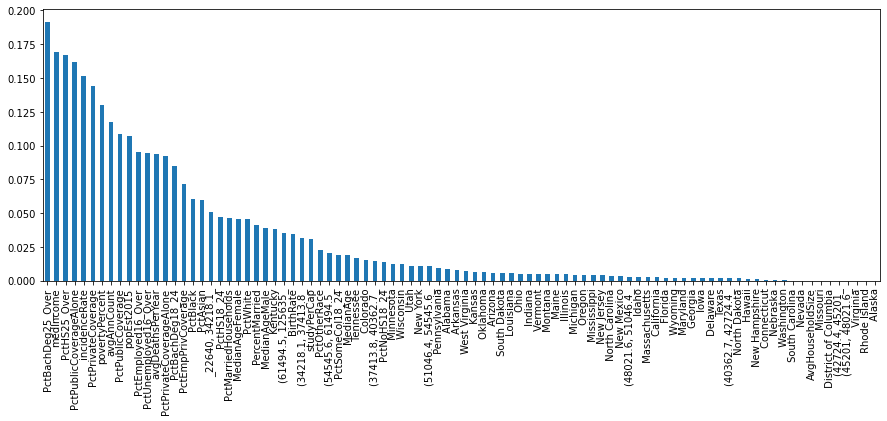

In [14]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5)) #plotting the features in the descending order of their dependency values

In [15]:
from sklearn.feature_selection import SelectKBest

#Taking top 20 important features
X_train_new= SelectKBest(mutual_info_regression, k=20).fit_transform(X_train.fillna(0),y_train)
print(X_train_new.shape,y_train.shape)



(2132, 20) (2132,)


**Features Selection for Test Values**

In [16]:
mutual_info= mutual_info_regression(X_test.fillna(0), y_test)
mutual_info

array([8.36387942e-02, 9.84076957e-02, 1.74898866e-01, 1.71405734e-01,
       8.72654122e-02, 1.83925291e-01, 1.73017643e-02, 2.32073541e-02,
       2.21863610e-02, 0.00000000e+00, 8.95934397e-02, 5.05796271e-02,
       2.29840929e-02, 6.14344376e-02, 2.19859374e-02, 8.85992712e-02,
       1.58818497e-01, 1.73196333e-01, 1.16528220e-01, 8.23306989e-02,
       1.41416706e-01, 1.44504665e-01, 9.31840613e-02, 1.90460298e-01,
       1.74415070e-01, 3.63010804e-02, 1.09111881e-01, 5.92780854e-02,
       2.70599434e-02, 5.45655283e-02, 3.55919291e-02, 9.27540381e-03,
       6.31387805e-04, 0.00000000e+00, 1.31634529e-02, 7.63992209e-03,
       2.11333134e-02, 4.08454224e-04, 0.00000000e+00, 2.05004115e-04,
       3.09785056e-03, 9.70753770e-03, 1.25422131e-04, 4.66327948e-03,
       1.14652299e-02, 5.38501158e-03, 1.75742843e-02, 0.00000000e+00,
       1.70274761e-02, 7.33755105e-03, 0.00000000e+00, 2.09258622e-03,
       8.58233409e-03, 4.37038782e-03, 6.71451209e-03, 1.93785223e-02,
      

In [17]:
mutual_info =pd.Series(mutual_info)
mutual_info.index=X_test.columns
mutual_info.sort_values(ascending=False)

PctPublicCoverage         0.190460
povertyPercent            0.183925
incidenceRate             0.174899
PctPublicCoverageAlone    0.174415
PctBachDeg25_Over         0.173196
                            ...   
 Wyoming                  0.000000
 Virginia                 0.000000
 Delaware                 0.000000
 Arizona                  0.000000
 Rhode Island             0.000000
Length: 92, dtype: float64

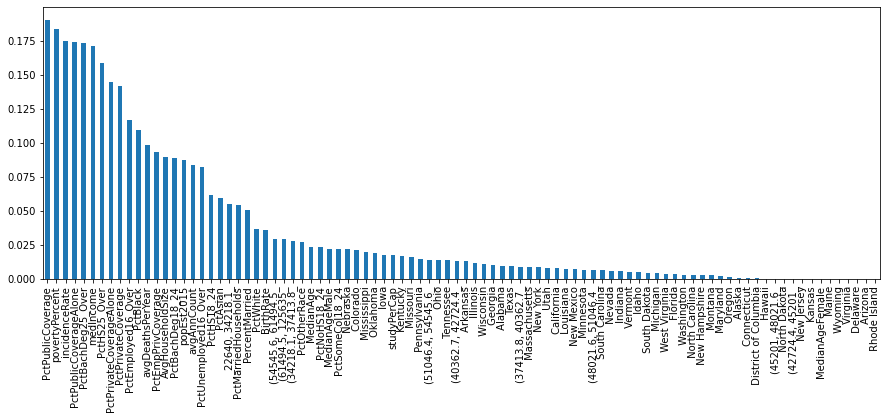

In [18]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

In [19]:
X_test_new= SelectKBest(mutual_info_regression, k=20).fit_transform(X_test.fillna(0),y_test)
X_test_new.shape


(915, 20)

**<H2>MODELLING</H2>**

Firstly All Models are trained with default Parameters. Which ever model have better MAE and less overfitt model is considered and hyper-parameter is done on that.

**XGBRegressor**

In [20]:
model_1=XGBRegressor()

model_1.fit(X_train_new,y_train)
model_1_train_pred=model_1.predict(X_train_new)  #Predictng for train values
model_1_test_pred=model_1.predict(X_test_new)  #predicting for test values


#calculating Mean absolute error for both train and test values
print("The train_MAE for XGB model",mean_absolute_error(y_train,model_1_train_pred))
print("The test_MAE for XGB model",mean_absolute_error(y_test,model_1_test_pred))

#creating dataframe for actual and predicted values
XGB_table=pd.DataFrame({'Predicted value':model_1_test_pred, 'Actual_value': y_test})

#Creating another column Absolute Difference(ADF) which finds abs diff between actual and predicted values
XGB_table["ADF"]= abs(XGB_table["Predicted value"]-XGB_table["Actual_value"])

XGB_table.head()

[07:23:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The train_MAE for XGB model 10.805782529247635
The test_MAE for XGB model 19.180918955985312


,Predicted value,Actual_value,ADF
0,173.463852,140.0,33.463852
1,193.465469,184.6,8.865469
2,199.213699,193.6,5.613699
3,188.971863,192.2,3.228137
4,210.503632,225.7,15.196368


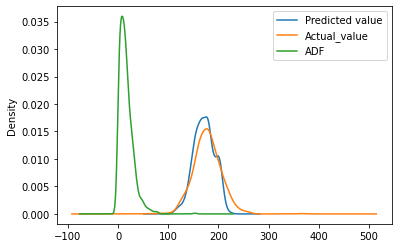

In [ ]:
ax = XGB_table.plot.kde() 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


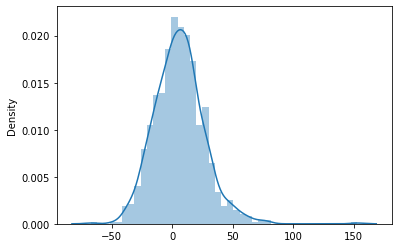

In [ ]:
sns.distplot(y_test-model_1_test_pred)

**ExtraTreesRegressor**

In [ ]:
model_2=ExtraTreesRegressor(n_estimators=400)

model_2.fit(X_train_new,y_train)
model_2_train_pred=model_2.predict(X_train_new)  #Predictng for train values
model_2_test_pred=model_2.predict(X_test_new)  #predicting for test values


#calculating Mean absolute error for both train and test values
print("The train_MAE  for LR model",mean_absolute_error(y_train,model_2_train_pred))
print("The test_MAE for LR model",mean_absolute_error(y_test,model_2_test_pred))


#creating dataframe for actual and predicted values
Extratree_table=pd.DataFrame({'Predicted value': model_2_test_pred, 'Actual_value': y_test})

#Creating another column Absolute Difference(ADF) which finds abs diff between actual and predicted values
Extratree_table["ADF"]= abs(Extratree_table["Predicted value"]-Extratree_table["Actual_value"])

Extratree_table.head()

The train_MAE  for LR model 7.842032214344423e-13
The test_MAE for LR model 18.982967759562836


,Predicted value,Actual_value,ADF
0,154.61150,140.0,14.61150
1,183.88450,184.6,0.71550
2,184.05750,193.6,9.54250
3,186.85675,192.2,5.34325
4,182.63825,225.7,43.06175


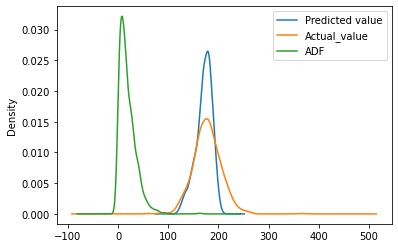

In [ ]:
yz =Extratree_table.plot.kde()

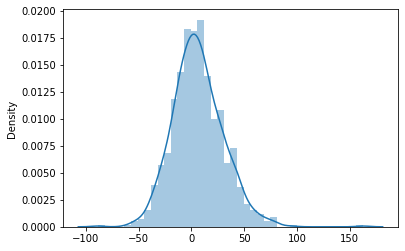

In [ ]:
sns.distplot(y_test-model_2_test_pred)

In [ ]:
model_3=DecisionTreeRegressor(max_depth=10, splitter='random',min_samples_leaf=3)

model_3.fit(X_train_new,y_train)
model_3_train_pred=model_3.predict(X_train_new)  #Predictng for train values
model_3_test_pred=model_3.predict(X_test_new)  #predicting for test values

#calculating Mean absolute error for both train and test values
print("The train_MSE  for DT model",mean_absolute_error(y_train,model_3_train_pred))
print("The test_MSE for DT model",mean_absolute_error(y_test,model_3_test_pred))


#creating dataframe for actual and predicted values
Decisiontree_table=pd.DataFrame({'Predicted value': model_3_test_pred, 'Actual_value': y_test})

#Creating another column Absolute Difference(ADF) which finds abs diff between actual and predicted values
Decisiontree_table["ADF"]= abs(Decisiontree_table["Predicted value"]-Decisiontree_table["Actual_value"])

Decisiontree_table.head()

The train_MSE  for DT model 11.360692662906859
The test_MSE for DT model 27.26865076999503


,Predicted value,Actual_value,ADF
0,119.566667,140.0,20.433333
1,180.140000,184.6,4.460000
2,183.600000,193.6,10.000000
3,181.266667,192.2,10.933333
4,154.450000,225.7,71.250000


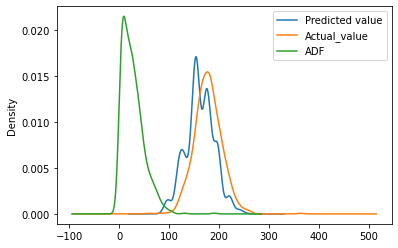

In [ ]:
yz =Decisiontree_table.plot.kde()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


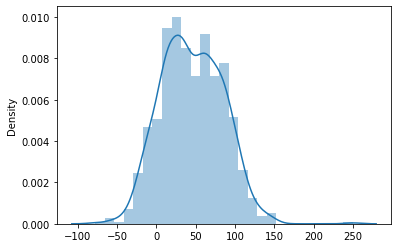

In [ ]:
sns.distplot(y_test-model_3_test_pred)

In [ ]:

model_4=RandomForestRegressor()

model_4.fit(X_train_new,y_train)
model_4_train_pred=model_4.predict(X_train_new)  #Predictng for train values
model_4_test_pred=model_4.predict(X_test_new)  #predicting for test values

#calculating Mean absolute error for both train and test values
print("The train_MAE  for RF model",mean_absolute_error(y_train,model_4_train_pred))
print("The test_MAE for RF model",mean_absolute_error(y_test,model_4_test_pred))

#creating dataframe for actual and predicted values
RF_table=pd.DataFrame({'Predicted value': model_4_test_pred, 'Actual_value': y_test})

#Creating another column Absolute Difference(ADF) which finds abs diff between actual and predicted values
RF_table["ADF"]= abs(RF_table["Predicted value"]-RF_table["Actual_value"])

RF_table.head()

The train_MAE  for RF model 5.312031425891177
The test_MAE for RF model 21.93733224043715


,Predicted value,Actual_value,ADF
0,134.024,140.0,5.976
1,208.814,184.6,24.214
2,179.903,193.6,13.697
3,190.273,192.2,1.927
4,203.251,225.7,22.449


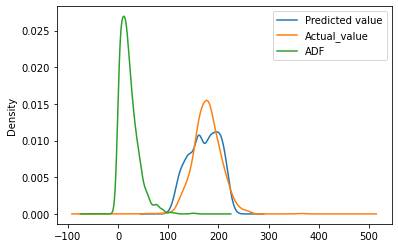

In [ ]:
yz =RF_table.plot.kde()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


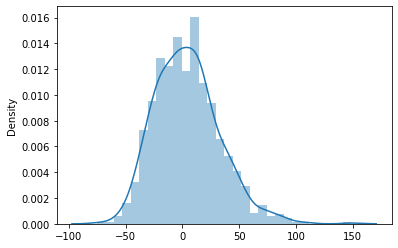

In [ ]:
sns.distplot(y_test-model_4_test_pred)

**SVR**

The train_MAE  for SVR model 20.55679475685159
The test_MAE for SVR model 20.186274537170746


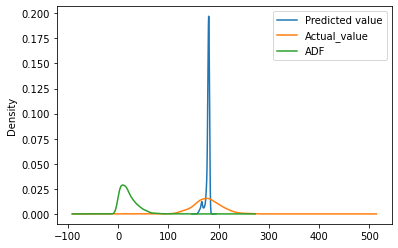

In [ ]:

model_5=SVR()

model_5.fit(X_train_new,y_train)
model_5_train_pred=model_5.predict(X_train_new)  #Predictng for train values
model_5_test_pred=model_5.predict(X_test_new)  #predicting for test values

#calculating Mean absolute error for both train and test values
print("The train_MAE  for SVR model",mean_absolute_error(y_train,model_5_train_pred))
print("The test_MAE for SVR model",mean_absolute_error(y_test,model_5_test_pred))


#creating dataframe for actual and predicted values
SVR_table=pd.DataFrame({'Predicted value': model_5_test_pred, 'Actual_value': y_test})

#Creating another column Absolute Difference(ADF) which finds abs diff between actual and predicted values
SVR_table["ADF"]= abs(SVR_table["Predicted value"]-SVR_table["Actual_value"])

SVR_table.head()

yz =SVR_table.plot.kde()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


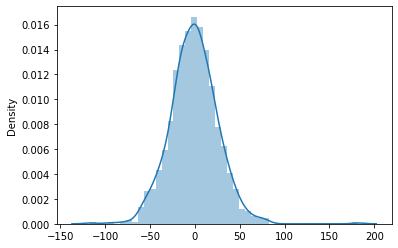

In [ ]:
sns.distplot(y_test-model_5_test_pred)

**LGBMRegressor**

The train_MAE  for LGBM model 5.008963618150652
The test_MAE for LGBM model 17.103135867762727


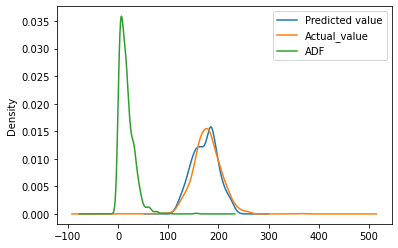

In [ ]:
model_6=LGBMRegressor()

model_6.fit(X_train_new,y_train)
model_6_train_pred=model_6.predict(X_train_new)  #Predictng for train values
model_6_test_pred=model_6.predict(X_test_new)  #predicting for test values

#calculating Mean absolute error for both train and test values
print("The train_MAE  for LGBM model",mean_absolute_error(y_train,model_6_train_pred))
print("The test_MAE for LGBM model",mean_absolute_error(y_test,model_6_test_pred))

#creating dataframe for actual and predicted values
LGBM_table=pd.DataFrame({'Predicted value': model_6_test_pred, 'Actual_value': y_test})

#Creating another column Absolute Difference(ADF) which finds abs diff between actual and predicted values
LGBM_table["ADF"]= abs(LGBM_table["Predicted value"]-LGBM_table["Actual_value"])

LGBM_table.head()

yz =LGBM_table.plot.kde()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


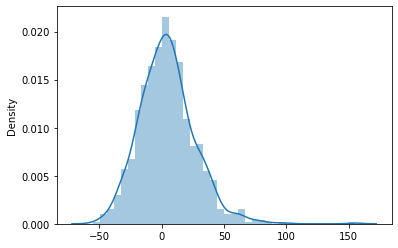

In [ ]:
sns.distplot(y_test-model_6_test_pred)

**LinearRegression**

The train_MAE  for LR model 14.768748986856835
The test_MAE for LRmodel 28.190984367620388


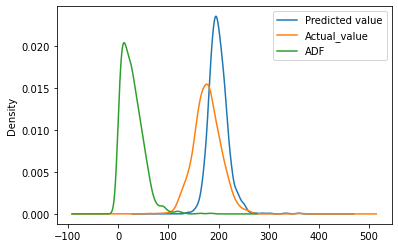

In [ ]:
model_7=LinearRegression()

model_7.fit(X_train_new,y_train)
model_7_train_pred=model_7.predict(X_train_new)  #Predictng for train values
model_7_test_pred=model_7.predict(X_test_new)  #predicting for test values


#calculating Mean absolute error for both train and test values
print("The train_MAE  for LR model",mean_absolute_error(y_train,model_7_train_pred))
print("The test_MAE for LRmodel",mean_absolute_error(y_test,model_7_test_pred))

#creating dataframe for actual and predicted values
LR_table=pd.DataFrame({'Predicted value': model_7_test_pred, 'Actual_value': y_test})

#Creating another column Absolute Difference(ADF) which finds abs diff between actual and predicted values
LR_table["ADF"]= abs(LR_table["Predicted value"]-LR_table["Actual_value"])

LR_table.head()

yz =LR_table.plot.kde()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


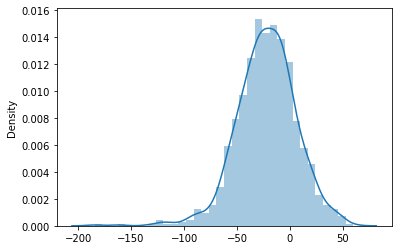

In [ ]:
sns.distplot(y_test-model_7_test_pred)

**Observation:** We are getting nearly bell shape curve for all most all the models which does not mean that our model is working good. Because good bell curve only tell us the range of predicted values are with in the same range as our original data range values are.

By Looking at all the Models the minimum MAE is for XGBRegressor model which is 16.28. This can be further imporved by Hyper Parameter Tunning.

**XGBRegressor Hyper-Parameter Tuning**

In [21]:
#Innitialising the Parameters
parameters={
            "max_depth" : [5,7,9],
            "n_estimators": [300,350,400,450],
            "learning_rate": [0.1,0.01,0.001]
           }

In [22]:
tuning_model=GridSearchCV(XGBRegressor(),param_grid=parameters,scoring='neg_mean_absolute_error',cv=3,verbose=3)
tuning_model.fit(X_train_new,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[07:24:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=-13.140 total time=   1.0s
[07:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=-13.104 total time=   1.0s
[07:24:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=-12.937 total time=   1.0s
[07:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=350;, score=-13.076 total time=   1.2s
[07:24:06] WARNING: /workspace/src/objecti

GridSearchCV(cv=3, estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [5, 7, 9],
                         'n_estimators': [300, 350, 400, 450]},
             scoring='neg_mean_absolute_error', verbose=3)

In [23]:
# best hyperparameters 
tuning_model.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 450}

In [24]:
# best model score
tuning_model.best_score_

-12.946041391385185

In [29]:
tuned_hyper_model=XGBRegressor(max_depth=5, n_estimators=450,learning_rate=0.1)
tuned_hyper_model.fit(X_train_new,y_train)
tunedmodel_train_pred=tuned_hyper_model.predict(X_train_new)  #Predictng for train values
tunedmodel_test_pred=tuned_hyper_model.predict(X_test_new)  #predicting for test values
tunedmodel_table=pd.DataFrame({'Predicted value':tunedmodel_test_pred, 'Actual_value': y_test})

tunedmodel_table["ADF"]= abs(tunedmodel_table["Predicted value"]-tunedmodel_table["Actual_value"])

print("The train_MAE for tunedmodel model",mean_absolute_error(y_train,tunedmodel_train_pred))
print("The test_MAE for tunedmodel model",mean_absolute_error(y_test,tunedmodel_test_pred))

[07:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The train_MAE for tunedmodel model 1.2425044161741101
The test_MAE for tunedmodel model 16.947121802158044


**Observation:** After doing a hyper paremeter tuning the MAE of test value is decreased but the model is overfiting. Tried to tune the model with more parameters but model is still getting overfitt. 